In [4]:
import yfinance

ticker = 'AAPL'
data = yfinance.download(ticker, start='2000-01-01', end='2025-01-01')
data = data[['Open',    'Close']]
data['returns'] = data['Close'].pct_change()

[*********************100%***********************]  1 of 1 completed


In [5]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np

def fit_arima(y: pd.Series, p_max, d_max, q_max):
    d = 0
    _y = y.copy()
    while d < d_max:
        res = adfuller(_y, autolag='AIC')
        if res[1] <= 0.05:
            break
        _y = _y.apply(np.log).diff().dropna()
        d += 1

    if d > 0:
        _y = y.apply(np.log).diff(d).dropna()
    else:
        _y = y.copy()

    best_order = (0, d, 0)
    best_score = np.inf
    for p in range(p_max + 1):
        for q in range(q_max + 1):
            if p == 0 and q == 0:
                continue
            try:
                model = ARIMA(_y, order=(p, d, q)).fit()
                if model.aic < best_score:
                    best_order = (p, d, q)
                    best_score = model.aic
            except:
                pass

    return ARIMA(y, order=best_order).fit()

In [6]:
import warnings
warnings.filterwarnings("ignore")

#params
train_span = 800
year_start = 2024

cash = 0

model = None
old_pos = 0
new_pos = 0

backtest_data: pd.DataFrame = data[data.index.year >= year_start]
backtest_data['cash'] = 0
backtest_data['pos'] = 0

for date, row in backtest_data.iterrows():
    if date.weekday() == 0 and len(data[:date] >= train_span):
        model = fit_arima(data.loc[:date, 'Close'].iloc[-train_span:], 6, 2, 6)
    if model:
        forecast = model.get_forecast(steps=1)
        mean = forecast.predicted_mean.iloc[0]
        std = np.sqrt(forecast.var_pred_mean.iloc[0])
        if mean > row['Close'].item() + std * 0.2:
            new_pos = 1
        elif mean < row['Close'].item() - std * 0.2:
            new_pos = -1
        else:
            new_pos = 0

    cash -= (new_pos - old_pos) * row['Close'].item()
    old_pos = new_pos
    
    backtest_data.loc[date, 'cash'] = cash
    backtest_data.loc[date, 'pos'] = new_pos



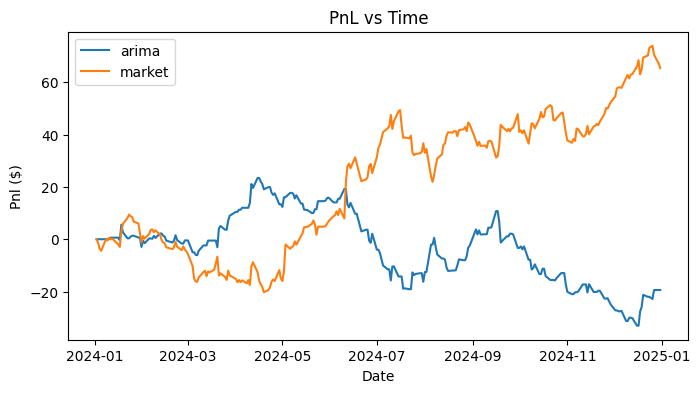

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.title('PnL vs Time')
plt.xlabel('Date')
plt.ylabel('Pnl ($)')
plt.plot(backtest_data['cash'] + backtest_data['pos'] * backtest_data['Close']['AAPL'], label='arima')
plt.plot(backtest_data['Close']['AAPL'] - backtest_data['Close']['AAPL'][0], label='market')
plt.legend()
plt.show()

In [14]:
print(f'final PnL: ${cash + old_pos * backtest_data['Close']['AAPL'][-1]:.2f}')

final PnL: $-19.43
